In [2]:
!pip install pdc

  Created wheel for pdc: filename=pdc-1.1.7-py3-none-any.whl size=5985 sha256=39264eb106273567ea604c396383593c359fd469000a38a96124585c8b0bb2dd
  Stored in directory: c:\users\sclab\appdata\local\pip\cache\wheels\76\d7\c4\79b7693b19a23cead4436c967e40ad2c54557c5ac820f95d57
Successfully built pdc


In [2]:
import pydicom as pdc
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import glob

### Dcm 이미지 
- original image
- preprocessed image applied Clahe 

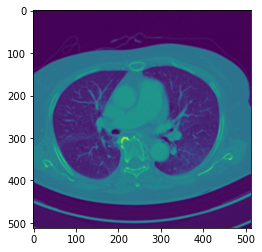

In [22]:
file_path = '../Code/benchmark_liver_tumor/raw/SN00017916/SN00017916_0001.dcm'
#file_path = '../Code/benchmark_liver_tumor/raw/SN00037077/SN00037077_0001.dcm'
sample = pdc.dcmread(file_path)
sample_np = sample.pixel_array
plt.imshow(sample_np)
plt.show()

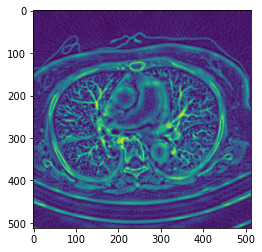

In [23]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32,32))
sameple_clahe = clahe.apply(sample_np)
plt.imshow(sameple_clahe)
plt.show()

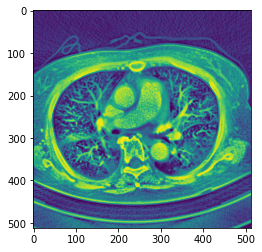

In [37]:
from skimage import exposure

sample_np_exp=exposure.equalize_adapthist(sample_np,clip_limit=0.03,nbins=512)
cv2.imshow('sample image dicom',sample_np_exp)

plt.imshow(sample_np_exp)

### Resize 를 통한 이미지 손실

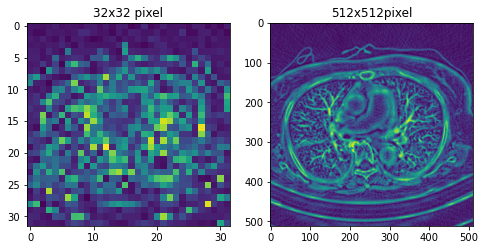

In [29]:
f, ax = plt.subplots(1,2, figsize=(8,6))

sample_clahe_resized_32 = cv2.resize(sameple_clahe, dsize=(32,32))    # 이미지 사이즈를 조정해준다.
ax[0].set_title("32x32 pixel")
ax[0].imshow(sample_clahe_resized_32)

sample_np_resized_512 = cv2.resize(sameple_clahe, dsize=(512,512))    # 이미지 사이즈를 조정해준다.
ax[1].set_title("512x512pixel")
ax[1].imshow(sample_np_resized_512)

#cv2.normalize(sample_np_resized_512, dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

plt.show()

### 이미지 전처리를 통한 SSIM, MSE 평가
- CLAHE 전/후
- Denoise 전/후

In [55]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

In [46]:
def compare_images(imageA, imageB, title):
    # index for the images
    m = mse(imageA, imageB)
    s = measure.compare_ssim(imageA, imageB)
    # setup the figure
    fig = plt.figure(title)
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")
    plt.show()

### BM3D를 통한 이미지 노이즈 제거

In [37]:
import bm3d
import skimage
from skimage.measure import compare_psnr

In [62]:
# Denoise via bm3d
noise_std_dev = 40

denoise = bm3d.bm3d(sample_np, noise_std_dev)
clahe_denoise = bm3d.bm3d(sameple_clahe, noise_std_dev)

#out_psnr = compare_psnr(noisy_img, out)
#plt.imshow(out)
#print("PSNR of reconstructed image: ", out_psnr)

<ipython-input-46-84f26354ef21>:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  s = measure.compare_ssim(imageA, imageB)


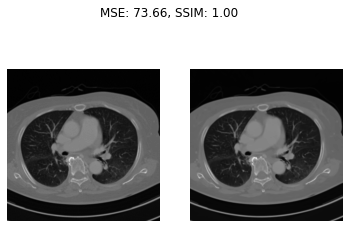

In [57]:
compare_images(sample_np,denoise,"Compare originalimage  with denoised image")

<ipython-input-46-84f26354ef21>:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  s = measure.compare_ssim(imageA, imageB)


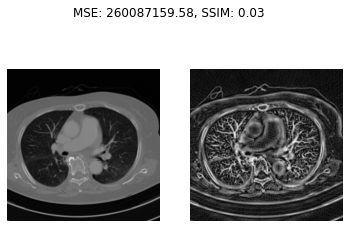

In [60]:
compare_images(sample_np,sameple_clahe,"CLAHE를 통한 전처리")

<ipython-input-46-84f26354ef21>:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  s = measure.compare_ssim(imageA, imageB)


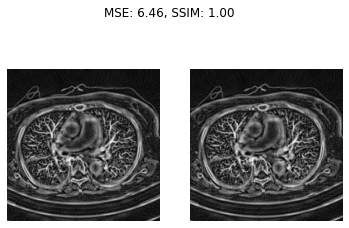

In [61]:
compare_images(clahe_denoise,sameple_clahe,"CLAHE 이미지 Denoise 전/후")

#### 분석
- bm3d를 통한 Denoise 는 큰 변화가 없다
- 적합한 Denoise 방법 구상 
- 노이즈가 많은 초음파, MRI 는 Denoise를 통한 전처리가 필요하다고 생각된다.